In [5]:
import sys
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import ariel_load
import tqdm
import copy
import importlib
import ariel_diagnostics
train_data = kgs.load_all_train_data()
kgs.sanity_checks_active = False

In [9]:
importlib.reload(ariel_load)
spectra = np.stack([d.spectrum for d in train_data])
means = np.mean(spectra,0)
inds = np.argsort(means)
mats = []
for ind in tqdm.tqdm(inds[-5:]):
    loaders = ariel_load.default_loaders()
    loaders[0].apply_pixel_corrections.mask_hot=False
    loaders[0].apply_pixel_corrections.mask_dead=True
    loaders[0].apply_pixel_corrections.flat_field=True
    #loaders[0].apply_pixel_corrections.cosmic_ray_threshold=5
    data = copy.deepcopy(train_data[ind])
    data.transits[0].load_to_step(2,data,loaders)
    mats.append(data.transits[0].data[0].data.get())

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

enable
enable
enable
enable
hi
hi


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.57s/it]

enable
enable
enable
enable
hi
hi


 40%|██████████████████████████████████                                                   | 2/5 [00:02<00:04,  1.45s/it]

enable
enable
enable
enable
hi
hi


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:04<00:02,  1.40s/it]

enable
enable
enable
enable
hi
hi


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:05<00:01,  1.37s/it]

enable
enable
enable
enable
hi
hi


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.40s/it]


In [10]:
mats[0][0,0,0]

-13.41821847333108

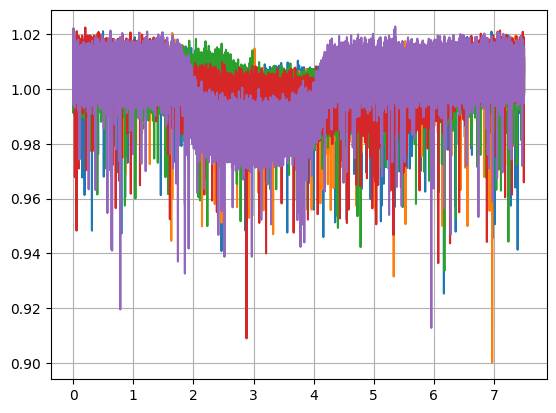

In [11]:
ma = 1
def time_series(mat):
    signal = np.nansum(mat,axis=(1,2))
    signal = signal/np.mean(signal)
    #signal = kgs.moving_average(signal, ma)
    return signal
plt.plot(kgs.moving_average(data.transits[0].data[0].times.get()/3600,ma),np.stack([time_series(mat) for mat in mats]).T)
plt.grid(True)

In [ ]:
ma = 100
def time_series(mat):
    signal = np.nansum(mat,axis=(1,2))
    signal = signal/np.mean(signal)
    signal = kgs.moving_average(signal, ma)
    return signal
plt.plot(kgs.moving_average(data.transits[0].data[0].times.get()/3600,ma),np.stack([time_series(mat) for mat in mats]).T)
plt.grid(True)

In [ ]:
# mat = mats[0]
# vals = time_series(mats)
# ind = np.argmin(vals)
# plt.imshow(mat[ind,...]-np.mean(mat,0))
# plt.colorbar()

In [ ]:
importlib.reload(ariel_diagnostics)
mats_avg = np.stack([np.log(np.mean(mat,0))/np.log(10) for mat in mats])
ariel_diagnostics.animate_3d_matrix(mats_avg, title='Mean over time for various transits (10log)')

In [ ]:
importlib.reload(ariel_diagnostics)
def rel_noise(mat):
    mn = np.mean(mat,0)
    rn = np.std(mat,0)/np.sqrt(mn)
    #rn[mn<1]=np.nan
    rn[rn>30]=30
    return rn
mats_avg = np.stack([rel_noise(mat) for mat in mats])
ariel_diagnostics.animate_3d_matrix(mats_avg, title='Relative noise for various transits')

In [ ]:
N=100
ii=2
ariel_diagnostics.animate_3d_matrix(kgs.moving_average(mats[ii]-np.mean(mats[ii],0),mats[ii].shape[0]//N)[::mats[ii].shape[0]//N,...])

In [ ]:
ii=2
#N=11250
mat = np.stack(mats[ii])
#mat = kgs.moving_average(mat-np.mean(mat,0),mats[ii].shape[0]//N)[::mats[ii].shape[0]//N,...]
print(mat.shape)
mat[np.isnan(mat)] = 0
mat = np.reshape(mat,(mat.shape[0],-1))
#mat[10000:20000,...] += 10000
X_centered = mat - np.mean(mat, 0)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_centered)
components = pca.components_          # Principal directions (eigenvectors)
components.shape
explained_variance = 1-np.cumsum(pca.explained_variance_ratio_)  # Variance explained by each PC
plt.figure()
plt.plot(explained_variance)

In [ ]:
plt.figure()
plt.imshow(np.reshape(np.mean(mat,0),(32,32)))
plt.figure()
plt.imshow(np.reshape(pca.components_[0,:],(32,32)));
plt.figure()
plt.imshow(np.reshape(pca.components_[1,:],(32,32)))
plt.figure()
plt.imshow(np.reshape(pca.components_[2,:],(32,32)))

In [ ]:
weights = X_centered @ components.T
plt.figure()
plt.plot(kgs.moving_average(weights,100));

In [ ]:
weights.shape, X_centered.shape, mat.shape

In [ ]:
plt.scatter(weights[:,0],np.nansum(mat,axis=(1)))

In [ ]:
N=100
plt.scatter(kgs.moving_average(weights[:,0],N),kgs.moving_average(np.nansum(mat,axis=(1)),N))

In [ ]:
ii=2
n_avg=100
time_series = np.nansum(mats[ii],axis=(1,2))
time_series = time_series[(n_avg-1)//2:-(n_avg-1)//2] - kgs.moving_average(time_series,n_avg)
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(time_series, lags=40)
plt.show()

In [ ]:
ii=2
n_avg=100
n_bin = 20
time_series = np.nansum(mats[ii],axis=(1,2))
binned = 0*time_series[::n_bin]
for ii in range(n_bin):
    binned+=time_series[ii::n_bin]
time_series=binned
time_series = time_series[(n_avg-1)//2:-(n_avg-1)//2] - kgs.moving_average(time_series,n_avg)
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(time_series, lags=40)
plt.show()

In [ ]:
5*4.7/0.4